In [1]:
import gdal
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#my code
from raster_sample import *
from profile_map_scanner import *




In [16]:
#Import the data
raster_path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/"
raster = gdal.Open(raster_path + "/Cache_creek_clip_HS.bil")#Get raster data

dem = raster.ReadAsArray()


creek= "Crack_canyon"
path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/Previous_LSDTT_version/Channel_extraction/"+creek+"/" #Set path to data

## IMPORT DATA
creek= "Crack_canyon"
path = "/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/Previous_LSDTT_version/Channel_extraction/"+creek+"/" #Set path to data
name = creek+"_MChiSegmented.csv" #Set file name
creek_data = np.genfromtxt((path+name), delimiter=',', skip_header=1, names=['node', 'row', 'col', 'latitude', 'longitude', 'chi', 'elevation', 'flow_distance', 'drainage_area', 'm_chi', 'b_chi', 'source_key', 'basin_key', 'segmented_elevation'])

#Create pandas dataframe
creek_data_df = pd.DataFrame(creek_data)

#Create a distance column in pandas dataframe
distance = creek_data_df['flow_distance'] - creek_data_df['flow_distance'].min()
creek_data_df['distance'] = distance

#convert the lat long to utm from creek data, chi segmented (only need this if there is no x, y columns)
creek_data_df = convert_lat_long(creek_data_df)

In [9]:
#Create a bokeh plot of the raster
import bokeh.plotting as bp
from bokeh.plotting import figure, show, output_file
from bokeh.layouts import gridplot, column


#pull out the products of raster subsampler
X,Y, array = raster_subsample_xy_generator(raster, creek_data_df)

#Create a bokeh source to use in interactive plots
source=bp.ColumnDataSource(creek_data_df)
color_by_variable('m_chi', source=source) #define color scheme for profiles

#define boundaries of the data
x_range, y_range = define_boundaries(source)
elev_range = define_elevation_boundaries(source)


#Create profile plots 

p = stream_map_raster(array, source, title='Map',x_axis_label='Easting', y_axis_label='Northing')

p2 = profile(elev_range, source, title='Elevation profile', x_axis_label='Distance', y_axis_label='Elevation')

p3 = profile(elev_range, source, x='chi', title='Chi profile', x_axis_label='Chi', y_axis_label='Elevation')


output_file("Profile comparison.html", title="Creek scanner")

plotcol = column(p2, p3)
grid = gridplot([[p, plotcol]])

bp.show(grid)  


In [196]:
#Import data for plotting best m/n ratio

#Im working on plotting data up using pandas to looke at MLE values for all m/n ratios of different channels,
#i want to do this all on the same plot, also should look into how to best visualize these data and if Mudd 
#and his group have already dones something like this. 

mle_data = []
df = pd.DataFrame()
for i in range(1,9):
    num = '0.'+str(i)
    name2 = path+creek+'_movernstats_'+num+'_fullstats.csv'
    mle_data_i = np.genfromtxt(name2, delimiter=',', skip_header=1, names=['basin_key', 'reference_source_key', 'test_source_key','MLE','RMSE'])
    
    mle_data.append(mle_data_i)
    
    df_temp = pd.DataFrame(mle_data_i)
    df = pd.concat([df,df_temp]) 
    
    
    
    

    
    
del df['basin_key']
del df['reference_source_key']
df = df.rename(columns={'test_source_key': 'Tributary #'})


# checking.head()

group = df.groupby(['Tributary #'])

#fig = plt.figure()
#section = df3[['MLE']]
#section.plot()
#plt.show()





In [209]:
%cd ~/VagrantBoxes/LSDTopoTools/Git_projects/LSDMappingTools/
from LSDPlottingTools import LSDMap_MOverNPlotting as MN
%cd ~/projects/profile_generator/

/Users/bmelosh/VagrantBoxes/LSDTopoTools/Git_projects/LSDMappingTools
/Users/bmelosh/projects/profile_generator


In [221]:
creek =  'Perkins_creek'
this_dir = '/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/Previous_LSDTT_version/Channel_extraction/'+creek+'/'
MN.MakeChiPlotsMLE(this_dir, creek,start_movern=0.1, d_movern=0.1, n_movern=7)#basin_list=[], , size_format=args.size_format, FigFormat = args.FigFormat)
#MN.PlotSensitivityResultsSigma(this_dir, 'Crack_canyon')





This m/n is: 0.1
This basin key is 0
Getting the reference_source_key
0.0
This m/n is: 0.2
This basin key is 0
Getting the reference_source_key
0.0
This m/n is: 0.3
This basin key is 0
Getting the reference_source_key
0.0
This m/n is: 0.4
This basin key is 0
Getting the reference_source_key
0.0
This m/n is: 0.5
This basin key is 0
Getting the reference_source_key
0.0
This m/n is: 0.6
This basin key is 0
Getting the reference_source_key
0.0
This m/n is: 0.7
This basin key is 0
Getting the reference_source_key
0.0


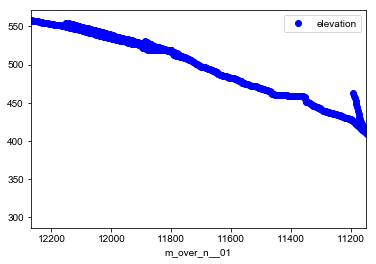

In [464]:
creek =  'Perkins_creek'
path = '/Users/bmelosh/VagrantBoxes/LSDTopoTools/Topographic_projects/Cache_creek/Previous_LSDTT_version/Channel_extraction/'+creek+'/'
name = creek+'_movern.csv'
#Import Data
creek_movern_data = np.genfromtxt((path+name), delimiter=',', skip_header=1, names=['source_key','basin_key','elevation','m_over_n = 0.1','m_over_n = 0.2','m_over_n = 0.3','m_over_n = 0.4','m_over_n = 0.5','m_over_n = 0.6','m_over_n = 0.7','m_over_n = 0.8'])

#creek_movern_df = pd.DataFrame(creek_movern_data)

creek_movern_df.head()
fig = plt.figure()
#creek_movern_df['elevation'].plot(style='bo')
creek_movern_df.plot(x='m_over_n__01', y='elevation', style='bo')

plt.show()

In [436]:
#Create array of mn values to iterate through (start_mn, end_mn, number of mn values)
mn_values = np.linspace(0.1,0.8,8)

#Iterate through all the files
name_mn = []
for mn in mn_values:
    name_mn_i = creek+'_movernstats_%s_fullstats.csv' %mn
    name_mn.append(name_mn_i)
    
dictionary = {}
MLE_arrary = []
for name in name_mn:
    dictionary["{0}".format(name)] = np.genfromtxt((path+name), delimiter=',', skip_header=1, names=['basin_key','reference_source_key','test_source_key','MLE','RMSE'])
    tributaries = len(dictionary["{0}".format(name)])
    #MLE_array = np.asarray(dictionary['{0}'.format(name)][0])

    
#Turn the dictionary into a pandas df if i want to
test = pd.DataFrame.from_dict(dictionary)
#test['Perkins_creek_movernstats_0.1_fullstats.csv'][2]

#Create a list of MLE values for every mn value of every tributary, ordered from low m/n to high m/n
#len(MLE_array)==number of tributaries
MLE_dict = []
for name in name_mn:

    MLE_array = []
    for trib in range(0,tributaries):
        MLE_array_trib = dictionary["{0}".format(name)][trib]
        #MLE_array = np.asarray(dictionary['{0}'.format(name)][0])
        MLE_array.append(MLE_array_trib)
    MLE_dict.append(MLE_array)





In [444]:
test['Perkins_creek_movernstats_0.1_fullstats.csv']#[0][3]
    
# get the colourmap to colour channels by the MLE value
            #NUM_COLORS = len(MLE)

# this_cmap = plt.cm.plasma
# cNorm  = colors.Normalize(vmin=np.min(MLE_array[0]), vmax=np.max(MLE_array[0]))
# plt.cm.ScalarMappable(norm=cNorm, cmap=this_cmap)

0     (0.0, 0.0, 1.0, 0.99898, 3.88927)
1    (0.0, 0.0, 2.0, 0.999562, 2.80474)
2    (0.0, 0.0, 3.0, 0.996681, 15.6095)
Name: Perkins_creek_movernstats_0.1_fullstats.csv, dtype: object

len(dictionary)

In [428]:
MLE =  []
for trib in range(0,tributaries):
    MLE_i = MLE_dict[0][trib][3]
    MLE.append(MLE_i)
    
MLE

[0.99897999999999998, 0.99956199999999995, 0.99668100000000004]

In [434]:
MLE_dict[1]#[2][3]

[(0.0, 0.0, 1.0, 0.999582, 2.50122),
 (0.0, 0.0, 2.0, 0.999768, 2.2053),
 (0.0, 0.0, 3.0, 0.997418, 13.3956)]